In [165]:
#import necessary libraries
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import math
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import requests
import collections
import re
import json
import seaborn as sns
from pandas.io.json import json_normalize
%matplotlib inline

In [2]:
# Read bike trip data from 2017-07 to 2019-04
tripdf=pd.DataFrame()
for filename in glob.glob("*tripdata.csv"):
    tripdf=tripdf.append(pd.read_csv(filename, parse_dates=["starttime", "stoptime"]))

In [3]:
# Inspect tripdf 
tripdf.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,463,2017-07-01 00:00:21,2017-07-01 00:08:05,22,South Station - 700 Atlantic Ave,42.352175,-71.055547,60,Charles Circle - Charles St at Cambridge St,42.360714,-71.070928,706,Subscriber,1993,1
1,689,2017-07-01 00:00:30,2017-07-01 00:12:00,22,South Station - 700 Atlantic Ave,42.352175,-71.055547,52,Newbury St at Hereford St,42.348717,-71.085954,565,Subscriber,1971,1
2,1377,2017-07-01 00:01:16,2017-07-01 00:24:14,41,Packard's Corner - Commonwealth Ave at Brighto...,42.352261,-71.123831,88,Inman Square at Vellucci Plaza / Hampshire St,42.374035,-71.101427,567,Subscriber,1979,1
3,74,2017-07-01 00:01:28,2017-07-01 00:02:43,116,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,116,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,484,Subscriber,1983,1
4,480,2017-07-01 00:02:06,2017-07-01 00:10:07,120,Charles st and Beacon St,42.356052,-71.069849,52,Newbury St at Hereford St,42.348717,-71.085954,48,Subscriber,1984,1


In [4]:
tripdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3043274 entries, 0 to 166693
Data columns (total 15 columns):
tripduration               int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id           int64
start station name         object
start station latitude     float64
start station longitude    float64
end station id             int64
end station name           object
end station latitude       float64
end station longitude      float64
bikeid                     int64
usertype                   object
birth year                 object
gender                     int64
dtypes: datetime64[ns](2), float64(4), int64(5), object(4)
memory usage: 371.5+ MB


In [6]:
tripdf.isnull().sum()

tripduration                  0
starttime                     0
stoptime                      0
start station id              0
start station name            0
start station latitude        0
start station longitude       0
end station id                0
end station name              0
end station latitude          0
end station longitude         0
bikeid                        0
usertype                      0
birth year                 9592
gender                        0
dtype: int64

In [7]:
# Fix the columns names in tripdf
tripdf.columns = tripdf.columns.str.replace(' ', '_')
tripdf.columns

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'birth_year', 'gender'],
      dtype='object')

In [9]:
# Inspect any anomalies by checking tripdf.describe()
tripdf.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,gender
count,3.043274e+06,3.043274e+06,3.043274e+06,3.043274e+06,3.043274e+06,3.043274e+06,3.043274e+06,3.043274e+06,3.043274e+06
mean,1.426353e+03,9.794769e+01,4.235738e+01,-7.108617e+01,9.777753e+01,4.235736e+01,-7.108581e+01,2.094717e+03,1.087222e+00
std,2.552807e+04,7.378661e+01,1.381469e-01,2.318688e-01,7.404229e+01,1.402569e-01,2.354184e-01,1.218827e+03,5.853337e-01
min,6.100000e+01,1.000000e+00,0.000000e+00,-7.116649e+01,1.000000e+00,0.000000e+00,-7.116649e+01,1.000000e+00,0.000000e+00
25%,4.020000e+02,4.500000e+01,4.234876e+01,-7.110394e+01,4.500000e+01,4.234876e+01,-7.110394e+01,1.025000e+03,1.000000e+00
50%,6.760000e+02,7.800000e+01,4.235810e+01,-7.108822e+01,7.800000e+01,4.235810e+01,-7.108809e+01,2.120000e+03,1.000000e+00
75%,1.132000e+03,1.410000e+02,4.236576e+01,-7.106629e+01,1.410000e+02,4.236567e+01,-7.106526e+01,3.089000e+03,1.000000e+00
max,9.328558e+06,3.840000e+02,4.240630e+01,0.000000e+00,3.840000e+02,4.240630e+01,0.000000e+00,4.626000e+03,2.000000e+00


In [15]:
# Inspect how many different start stations and end stations exist in tripdf
print(tripdf.start_station_name.nunique())
print(tripdf.start_station_id.nunique())

print(tripdf.end_station_name.nunique())
print(tripdf.end_station_id.nunique())

print(tripdf.start_station_latitude.nunique())
print(tripdf.start_station_longitude.nunique())

print(tripdf.end_station_latitude.nunique())
print(tripdf.end_station_longitude.nunique())

347
321
348
321
365
366
365
366


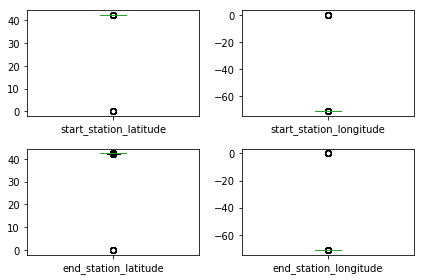

In [90]:
# Create a box plot to check outliers
fig=plt.figure()
plt.subplot(2,2,1)
tripdf.start_station_latitude.plot(kind="box")
plt.subplot(2,2,2)
tripdf.start_station_longitude.plot(kind="box")
plt.subplot(2,2,3)
tripdf.end_station_latitude.plot(kind="box")
plt.subplot(2,2,4)
tripdf.end_station_longitude.plot(kind="box")
plt.tight_layout()

384


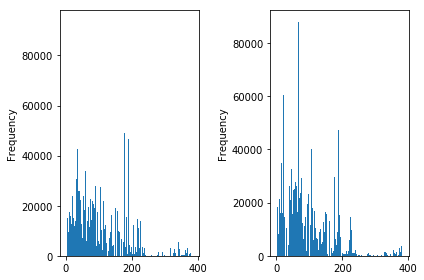

In [89]:
# Check how the biggest id number
print(tripdf.start_station_id.max())

# Check the distribution of start station id's
fig = plt.figure()

plt.subplot(1,2,1)
tripdf.start_station_id.plot(kind="hist", bins=384)

# Check the distribution of end station id's
plt.subplot(1,2,2)
tripdf.end_station_id.plot(kind="hist", bins=384)
plt.tight_layout()

In [16]:
# Take core columns from tripdf
trip_simp=tripdf[["start_station_id", "end_station_id", "starttime", "stoptime", 
                  "tripduration", "bikeid", "usertype", "birth_year"]]

In [17]:
# Call the API and pull out data
# into the JSON structure that will be returned
r=requests.get("https://member.bluebikes.com/data/stations.json")
bike_data=r.json()

In [19]:
print(bike_data.keys())
station=json_normalize(bike_data["stations"])
station.head(10)

dict_keys(['stations', 'schemeSuspended', 'timestamp'])


,b,ba,bk,bl,bx,d,da,dx,id,la,lc,lo,lu,m,n,s,st,su
0,False,10,True,True,0,Boston,4,1,3,42.340115,1.559004e+12,-71.100619,1559002295557,False,B32006,Colleges of the Fenway - Fenway at Avenue Loui...,1,False
1,False,15,False,False,2,Boston,2,0,4,42.345392,1.559004e+12,-71.069616,1559003125786,False,C32000,Tremont St at E Berkeley St,1,False
2,False,1,False,False,2,Boston,12,0,5,42.341814,1.559004e+12,-71.090179,1559003649960,False,B32012,Northeastern University - North Parking Lot,1,False
3,False,13,False,False,2,Boston,0,0,6,42.361212,1.559004e+12,-71.065306,1559004021089,False,D32000,Cambridge St at Joy St,1,False
4,False,1,False,False,0,Boston,14,0,7,42.353391,1.559004e+12,-71.044571,1559002452838,False,A32000,Fan Pier,1,False
5,False,11,False,False,0,Boston,8,0,8,42.353334,1.559004e+12,-71.137313,1559003048038,False,A32001,Union Square - Brighton Ave at Cambridge St,1,False
6,False,3,False,False,2,Boston,9,0,9,42.351692,1.559004e+12,-71.119035,1559002469644,False,A32002,Commonwealth Ave at Agganis Way,1,False
7,False,0,False,False,2,Boston,9,0,10,42.350406,1.559004e+12,-71.108279,1559001338165,False,A32003,B.U. Central - 725 Comm. Ave.,1,False
8,False,5,False,False,0,Boston,10,0,11,42.338629,1.559004e+12,-71.106500,1559003421208,False,A32004,Longwood Ave at Binney St,1,False
9,False,4,True,True,0,Boston,14,0,12,42.336244,1.559004e+12,-71.087986,1559003606984,False,B32002,Ruggles T Stop - Columbus Ave at Melnea Cass Blvd,1,False


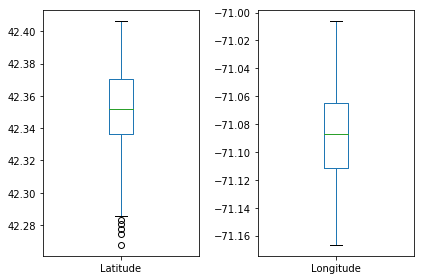

In [87]:
# Create a box plot to check outliers
fig = plt.figure()
plt.subplot(1,2,1)
station.Latitude.plot(kind="box")
plt.subplot(1,2,2)
station.Longitude.plot(kind="box")
plt.tight_layout()

In [20]:
#Only take station id, station detailed id, station name, latitude, longitude, 
#district(municipality), bike available, (empty) dock available
station=station[["id", "s", "la", "lo", "d", "ba","da"]]

In [22]:
#bike available + (emtpy) dock available  = total number of docks
station["#_of_Docks"] = station.ba + station.da
# drop ba, da
station=station.drop(["ba", "da"], axis=1)

station.head()

,id,s,la,lo,d,#_of_Docks
0,3,Colleges of the Fenway - Fenway at Avenue Loui...,42.340115,-71.100619,Boston,14
1,4,Tremont St at E Berkeley St,42.345392,-71.069616,Boston,17
2,5,Northeastern University - North Parking Lot,42.341814,-71.090179,Boston,13
3,6,Cambridge St at Joy St,42.361212,-71.065306,Boston,13
4,7,Fan Pier,42.353391,-71.044571,Boston,15


In [84]:
# Update column naames
station.columns=["ID", "Station", "Latitude", "Longitude", "Municipality", "#_of_Docks"]

In [85]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 6 columns):
ID              277 non-null int64
Station         277 non-null object
Latitude        277 non-null float64
Longitude       277 non-null float64
Municipality    277 non-null object
#_of_Docks      277 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 13.1+ KB


In [50]:
# Merge trip_simp and station
trip_endinfo=pd.merge(trip_simp, station, left_on="end_station_id", right_on="ID", how="outer")
trip_endinfo.head(5)

,start_station_id,end_station_id,starttime,stoptime,tripduration,bikeid,usertype,birth_year,ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
0,22.0,60.0,2017-07-01 00:00:21,2017-07-01 00:08:05,463.0,706.0,Subscriber,1993,60.0,Charles Circle - Charles St at Cambridge St,42.360185,-71.070866,Boston,10.0
1,176.0,60.0,2017-07-01 00:44:25,2017-07-01 01:06:31,1326.0,1612.0,Subscriber,1985,60.0,Charles Circle - Charles St at Cambridge St,42.360185,-71.070866,Boston,10.0
2,9.0,60.0,2017-07-01 00:44:29,2017-07-01 01:14:16,1786.0,1107.0,Subscriber,1997,60.0,Charles Circle - Charles St at Cambridge St,42.360185,-71.070866,Boston,10.0
3,23.0,60.0,2017-07-01 01:50:33,2017-07-01 01:55:39,305.0,1748.0,Subscriber,1991,60.0,Charles Circle - Charles St at Cambridge St,42.360185,-71.070866,Boston,10.0
4,13.0,60.0,2017-07-01 06:13:57,2017-07-01 06:26:05,728.0,1712.0,Subscriber,1990,60.0,Charles Circle - Charles St at Cambridge St,42.360185,-71.070866,Boston,10.0


In [51]:
unmatched=trip_endinfo[trip_endinfo.ID.isnull()].groupby(["end_station_id"]).first()
unmatched.head(10)

,start_station_id,starttime,stoptime,tripduration,bikeid,usertype,birth_year,ID,Station,Latitude,Longtitude,Municipality,#_of_Docks
end_station_id,,,,,,,,,,,,,
1.0,61.0,2017-07-01 16:46:26.000,2017-07-11 21:39:23.000,881576.0,1310.0,Customer,\N,NaN,NaN,NaN,NaN,NaN,NaN
13.0,133.0,2017-07-01 06:24:50.000,2017-07-01 06:52:18.000,1647.0,1430.0,Subscriber,1987,NaN,NaN,NaN,NaN,NaN,NaN
88.0,41.0,2017-07-01 00:01:16.000,2017-07-01 00:24:14.000,1377.0,567.0,Subscriber,1979,NaN,NaN,NaN,NaN,NaN,NaN
155.0,48.0,2018-09-05 17:14:58.955,2018-09-05 18:21:09.723,3970.0,422.0,Customer,1969,NaN,NaN,NaN,NaN,NaN,NaN
158.0,158.0,2018-07-18 15:07:22.585,2018-07-18 15:11:13.793,231.0,1583.0,Customer,1969,NaN,NaN,NaN,NaN,NaN,NaN
164.0,33.0,2017-10-18 15:43:25.000,2017-10-18 15:49:03.000,337.0,1809.0,Subscriber,1990,NaN,NaN,NaN,NaN,NaN,NaN
168.0,74.0,2018-08-09 20:02:31.166,2018-08-09 20:12:07.942,576.0,2757.0,Customer,1988,NaN,NaN,NaN,NaN,NaN,NaN
220.0,188.0,2018-07-31 18:14:33.643,2018-07-31 18:29:37.624,903.0,2423.0,Subscriber,1992,NaN,NaN,NaN,NaN,NaN,NaN
229.0,229.0,2017-09-08 13:00:13.000,2017-09-08 13:14:55.000,881.0,1583.0,Customer,\N,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
len(unmatched)

50

In [53]:
fixidlist=unmatched.index.values
fixidlist = fixidlist.astype(int)
fixidlist

array([  1,  13,  88, 155, 158, 164, 168, 220, 229, 230, 231, 237, 238,
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 252, 253,
       254, 256, 257, 262, 263, 264, 274, 277, 278, 281, 283, 284, 286,
       293, 294, 295, 299, 300, 302, 306, 307, 308, 311, 317])

In [61]:
fixdict = {1:np.nan, 13:385, 88:381, 155:331, 158:np.nan, 164:np.nan, 168:332, 220:328, 229:np.nan,
           230:np.nan, 231:329, 237:333, 238:334, 240:335, 241:336, 242:337, 243:338, 244:339, 
           245:340, 246:341, 247:342, 248:343, 249:344,250:345, 252:346, 253:347, 254:348, 256:349, 
           257:350, 262:351, 263:353, 264:354, 274:355, 277:356, 278:357, 281:358, 283:327, 284:359, 
           286:330, 293:360, 294:361, 295:362, 299:363, 300:364, 302:365, 306:368, 307:366, 308:np.nan, 
           311:367, 317:np.nan}

In [66]:
trip_simp=trip_simp.replace({"start_station_id":fixdict})
trip_simp=trip_simp.replace({"end_station_id":fixdict})

In [64]:
trip_simp=trip_simp.dropna(subset=["start_station_id"])
trip_simp=trip_simp.dropna(subset=["end_station_id"])

In [68]:
trip_simp.isnull().sum()

start_station_id       0
end_station_id         0
starttime              0
stoptime               0
tripduration           0
bikeid                 0
usertype               0
birth_year          9586
dtype: int64

In [77]:
trip_simp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3041796 entries, 0 to 166693
Data columns (total 8 columns):
start_station_id    int64
end_station_id      int64
starttime           datetime64[ns]
stoptime            datetime64[ns]
tripduration        int64
bikeid              int64
usertype            object
birth_year          object
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 208.9+ MB


In [76]:
trip_simp.start_station_id = trip_simp.start_station_id.astype(int)
trip_simp.end_station_id = trip_simp.end_station_id.astype(int)

In [78]:
trip_simp.to_csv("trip_simp.csv")

In [71]:
print(trip_simp.start_station_id.nunique())
print(trip_simp.end_station_id.nunique())
print(station.ID.nunique())

272
272
277


In [72]:
set(sorted(station.ID.unique()))-set(sorted(trip_simp.end_station_id.unique()))

{268, 271, 272, 273, 386}

In [92]:
trip_simp.head()

,start_station_id,end_station_id,starttime,stoptime,tripduration,bikeid,usertype,birth_year
0,22,60,2017-07-01 00:00:21,2017-07-01 00:08:05,463,706,Subscriber,1993
1,22,52,2017-07-01 00:00:30,2017-07-01 00:12:00,689,565,Subscriber,1971
2,41,381,2017-07-01 00:01:16,2017-07-01 00:24:14,1377,567,Subscriber,1979
3,116,116,2017-07-01 00:01:28,2017-07-01 00:02:43,74,484,Subscriber,1983
4,120,52,2017-07-01 00:02:06,2017-07-01 00:10:07,480,48,Subscriber,1984


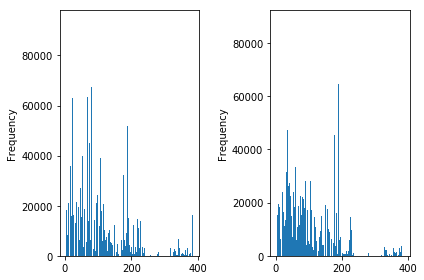

In [107]:
# Check the distribution of start station id's
fig = plt.figure()

plt.subplot(1,2,1)
trip_simp.start_station_id.plot(kind="hist", bins=384)

plt.subplot(1,2,2)
trip_simp.end_station_id.plot(kind="hist", bins=384)

plt.tight_layout()

In [97]:
# Find popular start stations
pop_starts=trip_simp.start_station_id.value_counts()
startslist=[]
for (start_id, value) in pop_starts.iteritems():
    startslist.append((start_id, station.loc[station.ID == start_id]["Station"].values[0],value))

[(67, 'MIT at Mass Ave / Amherst St', 93527),
 (80, 'MIT Stata Center at Vassar St / Main St', 67344),
 (68, 'Central Square at Mass Ave / Essex St', 63548),
 (22, 'South Station - 700 Atlantic Ave', 63188),
 (189, 'Kendall T', 51670)]

In [98]:
# Find popular end stations
pop_ends=trip_simp.end_station_id.value_counts()
endslist=[]
for (end_id, value) in pop_ends.iteritems():
    endslist.append((end_id, station.loc[station.ID == end_id]["Station"].values[0],value))

[(67, 'MIT at Mass Ave / Amherst St', 88006),
 (80, 'MIT Stata Center at Vassar St / Main St', 79127),
 (190, 'Nashua Street at Red Auerbach Way', 64685),
 (68, 'Central Square at Mass Ave / Essex St', 63526),
 (22, 'South Station - 700 Atlantic Ave', 60526)]

In [99]:
pop_starts_df=pd.DataFrame(startslist)
pop_starts_df.columns=["start_station_id", "start_station_name", "count"]
pop_ends_df=pd.DataFrame(endslist)
pop_ends_df.columns=["end_station_id", "end_station_name", "count"]

In [101]:
pop_starts_df.head()

,start_station_id,start_station_name,count
0,67,MIT at Mass Ave / Amherst St,93527
1,80,MIT Stata Center at Vassar St / Main St,67344
2,68,Central Square at Mass Ave / Essex St,63548
3,22,South Station - 700 Atlantic Ave,63188
4,189,Kendall T,51670


In [102]:
pop_ends_df.head()

,end_station_id,end_station_name,count
0,67,MIT at Mass Ave / Amherst St,88006
1,80,MIT Stata Center at Vassar St / Main St,79127
2,190,Nashua Street at Red Auerbach Way,64685
3,68,Central Square at Mass Ave / Essex St,63526
4,22,South Station - 700 Atlantic Ave,60526


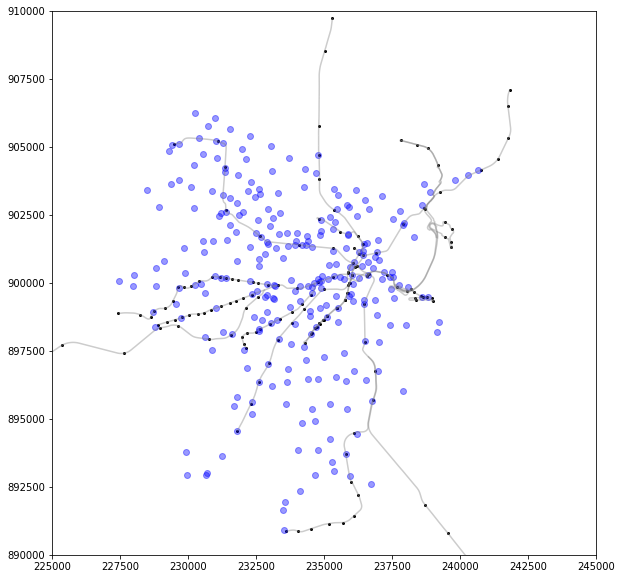

In [139]:
crs= {'init':'epsg:4326'}
geometry= [Point(xy) for xy in zip(station.Longitude, station.Latitude)]
station_geo= gpd.GeoDataFrame(station, crs=crs, geometry = geometry)
station_geo_trans = station_geo.to_crs(epsg=26986)
metroarc= gpd.read_file("mbta_rapid_transit/MBTA_ARC.shp")
metronode= gpd.read_file("mbta_rapid_transit/MBTA_NODE.shp")
fig, ax=plt.subplots(figsize=(10,10))
ax.set_xlim([225000, 245000])
ax.set_ylim([890000, 910000])
metroarc.plot(ax=ax, alpha=0.4, color="grey")
metronode.plot(ax=ax, color="k",  markersize=4)
station_geo_trans.plot(ax=ax, color="blue", alpha=0.4)
plt.show()

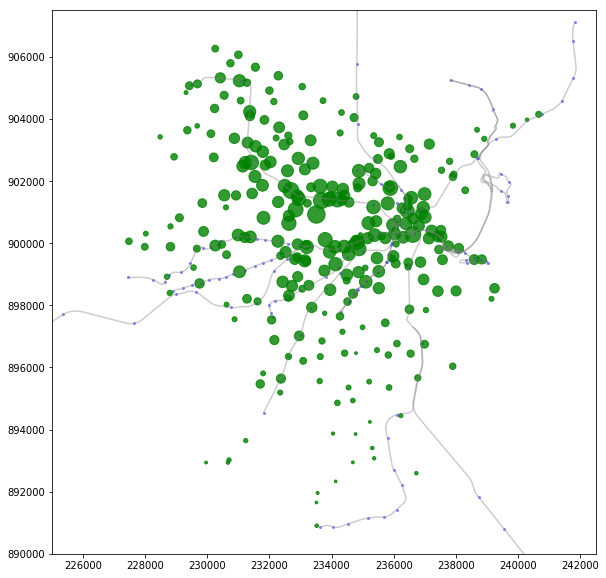

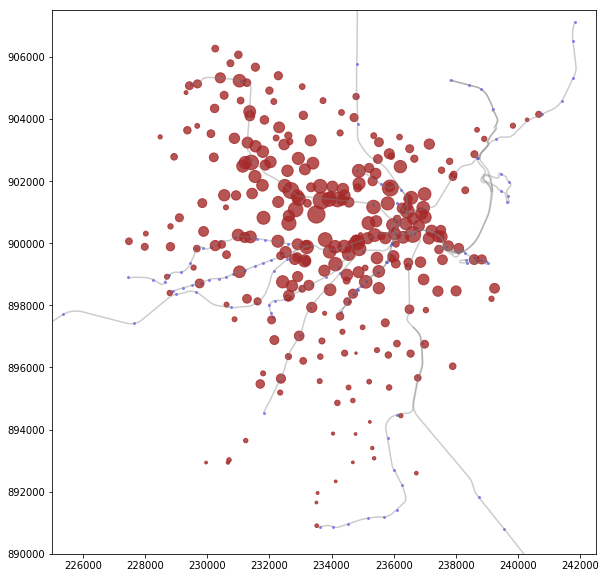

In [141]:

crs={'init':'epsg:4326'}
pop_starts_loc=pd.merge(pop_starts_df, station[["ID", "Latitude", "Longitude"]], left_on="start_station_id", right_on="ID", how="left")
geometry=[Point(xy) for xy in zip(pop_starts_loc.Longitude, pop_starts_loc.Latitude)]
pop_starts_geo=gpd.GeoDataFrame(pop_starts_loc, crs=crs, geometry = geometry).to_crs(epsg=26986)
fig, ax=plt.subplots(figsize=(10,10))
ax.set_xlim([225000, 242500])
ax.set_ylim([890000, 907500])
metroarc.plot(ax=ax, alpha=0.4, color="grey")
metronode.plot(ax=ax, alpha=0.4, color="blue",  markersize=4)
pop_starts_geo.plot(ax=ax, color="green", alpha=0.8, markersize=[math.pow(n, 0.5) for n in pop_starts_geo["count"]])


crs={'init':'epsg:4326'}
pop_ends_loc=pd.merge(pop_ends_df, station[["ID", "Latitude", "Longitude"]], left_on="end_station_id", right_on="ID", how="left")
geometry=[Point(xy) for xy in zip(pop_ends_loc.Longitude, pop_ends_loc.Latitude)]
pop_ends_geo=gpd.GeoDataFrame(pop_ends_loc, crs=crs, geometry = geometry).to_crs(epsg=26986)
fig, ax=plt.subplots(figsize=(10, 10))
ax.set_xlim([225000, 242500])
ax.set_ylim([890000, 907500])
metroarc.plot(ax=ax, alpha=0.4, color="grey")
metronode.plot(ax=ax, alpha=0.4, color="blue",  markersize=4)
pop_ends_geo.plot(ax=ax, color="brown", alpha=0.8, markersize=[math.pow(n, 0.5) for n in pop_ends_geo["count"]])


In [143]:
daily=pd.read_csv("DailyWeather.csv", low_memory=False, parse_dates=["DATE"])
daily=daily.set_index("DATE")

In [151]:
daily.isnull().sum()

STATION          0
NAME             0
LATITUDE         0
LONGITUDE        0
ELEVATION        0
AWND         58764
PRCP          1529
PSUN         62107
SNOW         24196
SNWD         36554
TAVG         62077
TMAX         47656
TMIN         47755
TSUN         62107
WT01         61693
WT02         62684
WT03         62536
WT04         62647
WT05         62739
WT06         62682
WT08         62631
WT09         62739
WT11         62672
dtype: int64

In [152]:
daily.notnull().sum()

STATION      62746
NAME         62746
LATITUDE     62746
LONGITUDE    62746
ELEVATION    62746
AWND          3982
PRCP         61217
PSUN           639
SNOW         38550
SNWD         26192
TAVG           669
TMAX         15090
TMIN         14991
TSUN           639
WT01          1053
WT02            62
WT03           210
WT04            99
WT05             7
WT06            64
WT08           115
WT09             7
WT11            74
dtype: int64

In [148]:
daily.groupby("NAME").mean()[15:20]

,LATITUDE,LONGITUDE,ELEVATION,AWND,PRCP,PSUN,SNOW,SNWD,TAVG,TMAX,...,TSUN,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
NAME,,,,,,,,,,,,,,,,,,,,,
"BILLERICA 2.0 W, MA US",42.5464,-71.3062,63.1,NaN,0.267636,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"BLUE HILL LCD, MA US",42.2123,-71.1137,190.5,11.640970,0.159296,51.021909,0.219718,0.938028,NaN,57.433490,...,368.389671,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
"BLUE HILL, MA US",42.2123,-71.1137,190.5,NaN,0.163797,NaN,0.208819,0.902695,NaN,57.397608,...,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.0
"BOSTON 0.5 WSW, MA US",42.3570,-71.0671,13.1,NaN,0.109006,NaN,0.029694,0.763934,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"BOSTON, MA US",42.3606,-71.0097,3.7,11.270688,0.130987,NaN,0.130493,0.000000,51.581465,59.203288,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


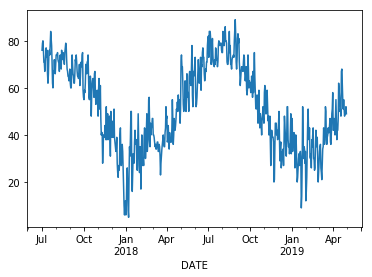

In [149]:
dailyBoston=daily[daily.NAME=="BOSTON, MA US"]
dailyBoston.TAVG.plot()

In [150]:
trip_time=trip_simp.set_index("starttime")
tripperday=trip_time.resample("D").count()
tripperday.head()

,start_station_id,end_station_id,stoptime,tripduration,bikeid,usertype,birth_year
starttime,,,,,,,
2017-07-01,4549,4549,4549,4549,4549,4549,4549
2017-07-02,4690,4690,4690,4690,4690,4690,4690
2017-07-03,5483,5483,5483,5483,5483,5483,5483
2017-07-04,5783,5783,5783,5783,5783,5783,5783
2017-07-05,6483,6483,6483,6483,6483,6483,6483


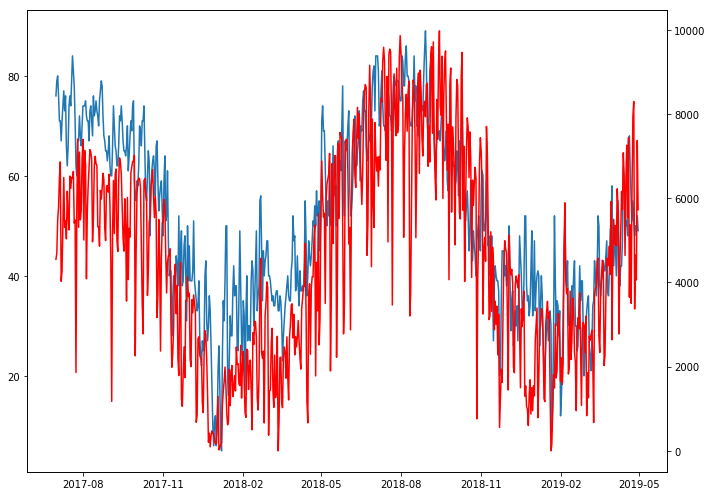

In [161]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(dailyBoston.TAVG)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(tripperday.tripduration, color="red")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

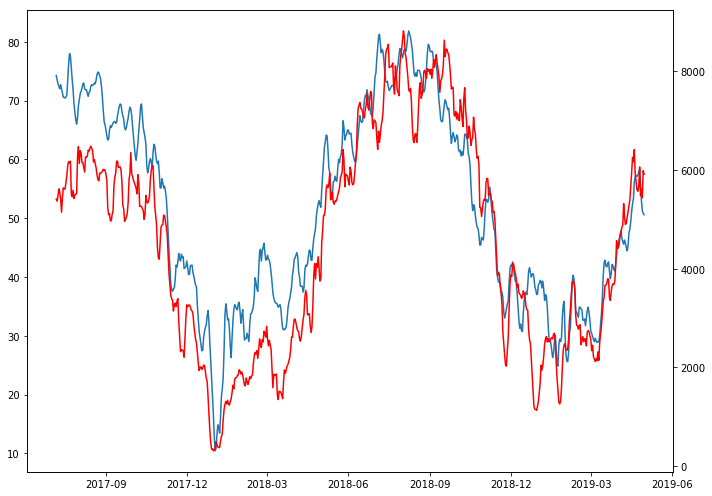

In [162]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(dailyBoston.TAVG.rolling(7).mean())

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(tripperday.tripduration.rolling(7).mean(), color="red")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [169]:
print(len(dailyBoston.TAVG))
print(len(tripperday.tripduration))

669
669


/Users/kkim14/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


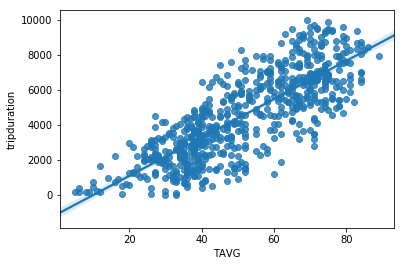

In [185]:
sns.regplot(dailyBoston.TAVG, tripperday.tripduration)

/Users/kkim14/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


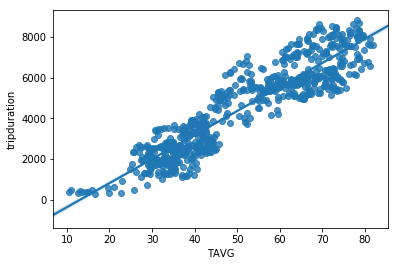

In [175]:
sns.regplot(dailyBoston.TAVG.rolling(7).mean(), tripperday.tripduration.rolling(7).mean())